Importing Libraries

In [52]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [53]:
IMAGE_SIZE = 256
BATCH_SIZE = 16

In [54]:
dataset_path = 'Yoga_Dataset'

In [55]:
# split into train and test
training_set = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.2,  # 80% train, 20% test
    subset="training"
)


Found 10668 files belonging to 8 classes.
Using 8535 files for training.


In [56]:
test_set = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 10668 files belonging to 8 classes.
Using 2133 files for validation.


In [57]:
# Get class names (pose names)
class_names = training_set.class_names
print("Classes:", class_names)

Classes: ['Adho Mukha Svanasana', 'Anjaneyasana', 'Phalakasana', 'Setu Bandha Sarvangasana', 'Trikonasana', 'Utkatasana', 'Virabhadrasana Two', 'Vrksasana']


In [58]:
# Normalization layer
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1.0 / 255)
])

In [59]:
# Define augmentation and normalization
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])

In [60]:
# Apply augmentation to training set, then normalize
training_set = training_set.map(lambda x, y: (resize_and_rescale(data_augmentation(x)), y))

In [61]:
# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)

In [62]:
#  Only normalize the test set (no augmentation)
test_set = test_set.map(lambda x, y: (resize_and_rescale(x), y))


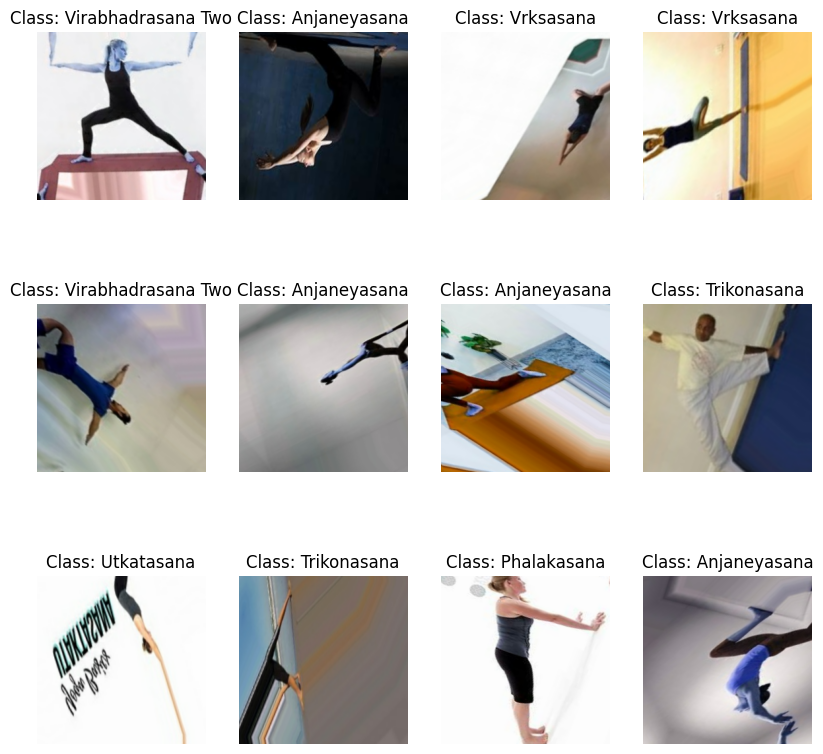

In [63]:
# Plotting a batch of augmented training images
plt.figure(figsize=(10, 10))
for image_batch, label_batch in training_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        img = image_batch[i].numpy() * 255  # Convert back to [0, 255] range
        img = img.astype("uint8")
        plt.imshow(img)
        plt.title("Class: " + class_names[label_batch[i].numpy()])
        plt.axis("off")
plt.show()

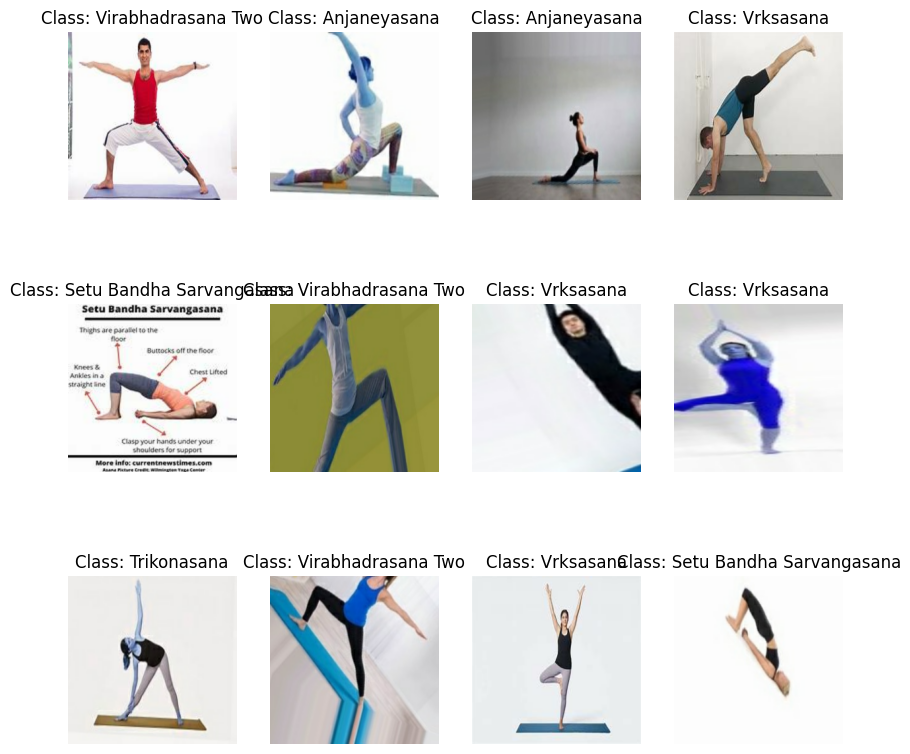

In [64]:
# Plotting a batch of test images (without augmentation)
plt.figure(figsize=(10, 10))
for image_batch, label_batch in test_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        img = image_batch[i].numpy() * 255
        img = img.astype("uint8")
        plt.imshow(img)
        plt.title("Class: " + class_names[label_batch[i].numpy()])
        plt.axis("off")
plt.show()

In [14]:
### END